In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_columns = None

In [2]:
file_path = '../data/raw/koi_cumulative_2.csv'
df = pd.read_csv(file_path)

In [3]:
cols_to_drop = [
    'kepid',
    'kepoi_name',
    'kepler_name',
    'koi_pdisposition',
    'koi_tce_delivname',
    'koi_fpflag_nt',
    'koi_sage',
]

In [4]:
df = df.drop(columns=cols_to_drop)

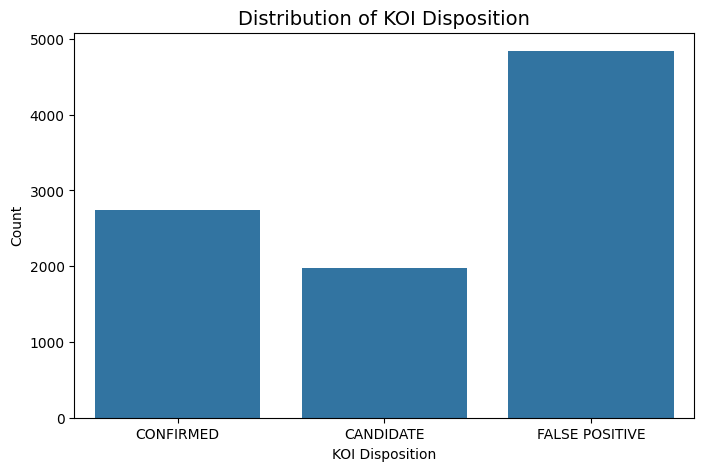

In [5]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='koi_disposition')
plt.title('Distribution of KOI Disposition', fontsize=14)
plt.xlabel('KOI Disposition')
plt.ylabel('Count')
plt.show()

In [6]:
df = df[df["koi_disposition"] != "CANDIDATE"]

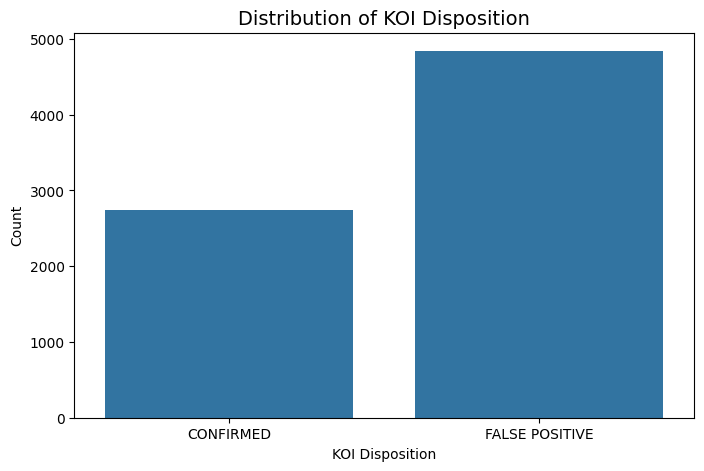

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='koi_disposition')
plt.title('Distribution of KOI Disposition', fontsize=14)
plt.xlabel('KOI Disposition')
plt.ylabel('Count')
plt.show()

In [8]:
df.isnull().mean() * 100

koi_disposition      0.000000
koi_score           12.002110
koi_fpflag_ss        0.000000
koi_fpflag_co        0.000000
koi_fpflag_ec        0.000000
koi_period           0.000000
koi_time0bk          0.000000
koi_impact           3.415985
koi_duration         0.000000
koi_depth            3.415985
koi_prad             3.415985
koi_teq              3.415985
koi_insol            2.888420
koi_model_snr        3.415985
koi_count            0.000000
koi_num_transits     8.981799
koi_tce_plnt_num     3.772092
koi_steff            3.415985
koi_slogg            3.415985
koi_smet             3.679768
koi_srad             3.415985
koi_smass            3.415985
koi_kepmag           0.013189
dtype: float64

In [9]:
cols = [var for var in df.columns if df[var].isnull().mean() < 0.05 and df[var].isnull().mean() > 0]
cols

['koi_impact',
 'koi_depth',
 'koi_prad',
 'koi_teq',
 'koi_insol',
 'koi_model_snr',
 'koi_tce_plnt_num',
 'koi_steff',
 'koi_slogg',
 'koi_smet',
 'koi_srad',
 'koi_smass',
 'koi_kepmag']

In [10]:
len(df[cols].dropna()) / len(df)

0.9362964916908467

In [11]:
new_df = df[cols].dropna()

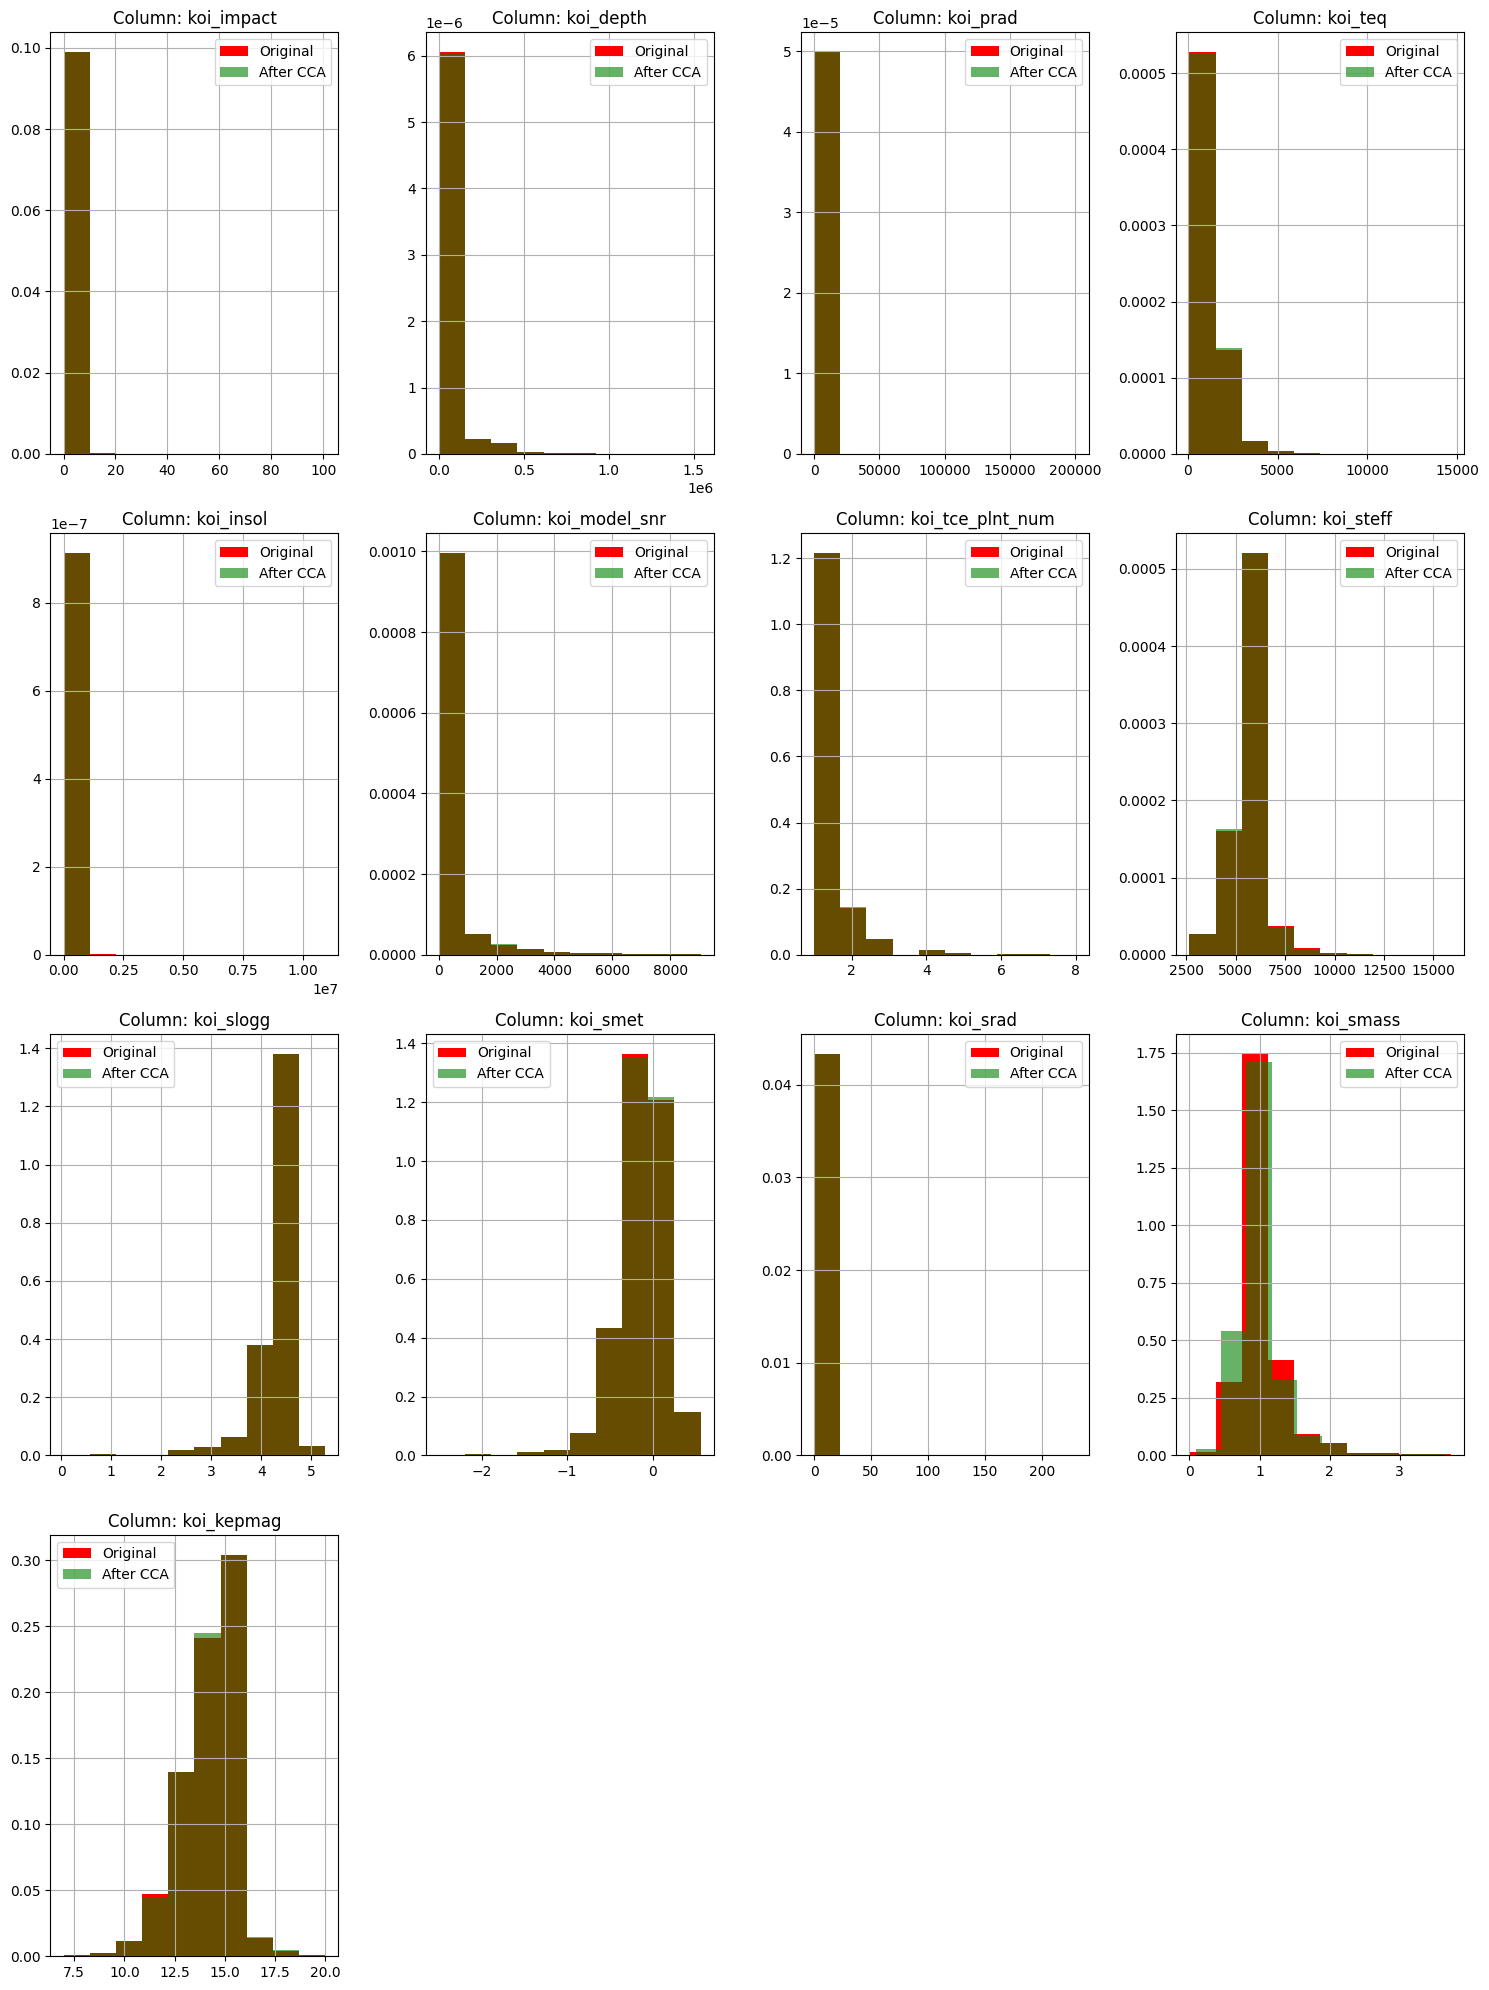

In [12]:
num_cols = len(cols)

cols_per_row = 4
rows = (num_cols // cols_per_row) + int(num_cols % cols_per_row != 0)

fig, axes = plt.subplots(rows, cols_per_row, figsize=(15, 5 * rows))
axes = axes.flatten()

for i, col in enumerate(cols):
    ax = axes[i]
    df[col].hist(ax=ax, density=True, color='red', label='Original')
    new_df[col].hist(ax=ax, density=True, color='green', label='After CCA', alpha=0.6)
    ax.set_title(f'Column: {col}')
    ax.legend()

for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

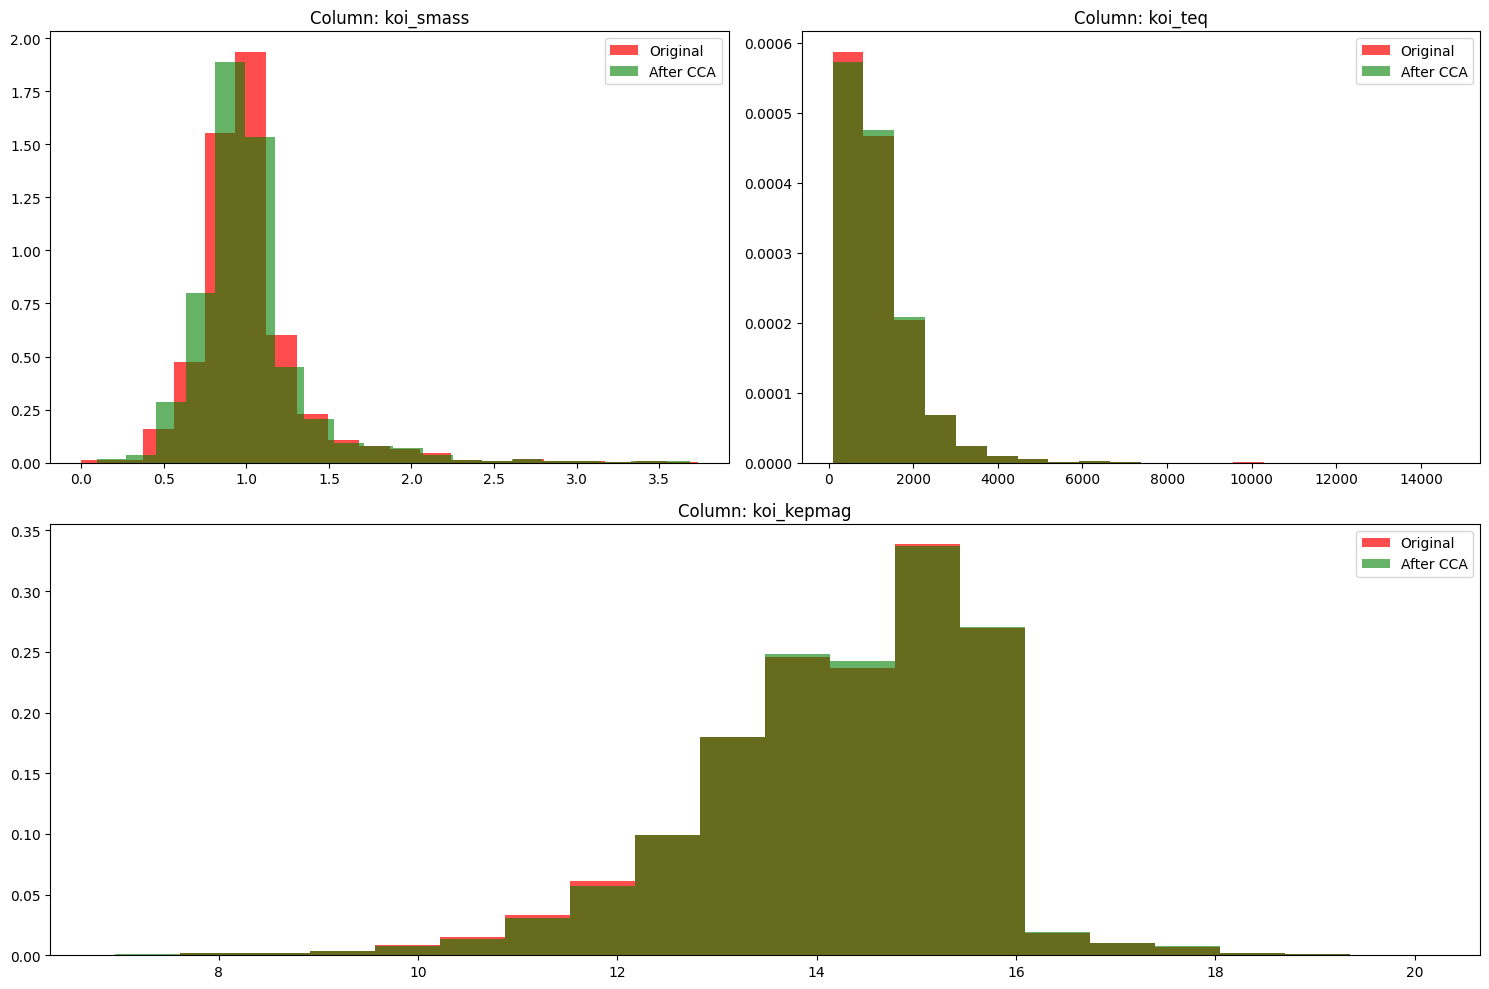

In [13]:
from matplotlib.gridspec import GridSpec

sample_cols = ['koi_smass', 'koi_teq', 'koi_kepmag']

fig = plt.figure(figsize=(15, 10))
gs = GridSpec(2, 2, height_ratios=[1, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax3 = fig.add_subplot(gs[1, :])

axes = [ax1, ax2, ax3]

for i, col in enumerate(sample_cols):
    axes[i].hist(df[col], density=True, color='red', label='Original', bins=20, alpha=0.7)
    axes[i].hist(new_df[col], density=True, color='green', label='After CCA', bins=20, alpha=0.6)
    axes[i].set_title(f'Column: {col}')
    axes[i].legend()

plt.tight_layout()
plt.show()

In [14]:
columns_to_impute = ['koi_smass', 'koi_num_transits', 'koi_score']
minimal_missing_columns = list(set(cols) - set(columns_to_impute))
complete_columns = list(set(df.columns) - set(minimal_missing_columns) - set(columns_to_impute))

In [15]:
columns_to_impute

['koi_smass', 'koi_num_transits', 'koi_score']

In [16]:
minimal_missing_columns

['koi_depth',
 'koi_smet',
 'koi_prad',
 'koi_insol',
 'koi_steff',
 'koi_model_snr',
 'koi_impact',
 'koi_teq',
 'koi_srad',
 'koi_kepmag',
 'koi_slogg',
 'koi_tce_plnt_num']

In [17]:
complete_columns

['koi_count',
 'koi_period',
 'koi_fpflag_ss',
 'koi_disposition',
 'koi_fpflag_co',
 'koi_fpflag_ec',
 'koi_time0bk',
 'koi_duration']

In [18]:
len(df.columns) == len(complete_columns) + len(minimal_missing_columns) + len(columns_to_impute)

True

In [19]:
df_filtered = df.dropna(subset=minimal_missing_columns)

In [20]:
len(df_filtered.columns)

23

In [21]:
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import SimpleImputer

# Make copies to compare different methods
df_knn = df_filtered.copy()
df_mice = df_filtered.copy()
df_rf = df_filtered.copy()
df_median = df_filtered.copy()

In [22]:
# KNN Imputation
knn_imputer = KNNImputer(n_neighbors=5)
df_knn[columns_to_impute] = knn_imputer.fit_transform(df_filtered[columns_to_impute])

# MICE Imputation
mice_imputer = IterativeImputer(
    random_state=42, 
    missing_values=np.nan
)
df_mice[columns_to_impute] = mice_imputer.fit_transform(df_filtered[columns_to_impute])

# Random Forest Imputation
rf_imputer = IterativeImputer(
    estimator=RandomForestRegressor(n_estimators=100, random_state=42),
    missing_values=np.nan,
    random_state=42
)
df_rf[columns_to_impute] = rf_imputer.fit_transform(df_filtered[columns_to_impute])

# SImple median imputer
median_imputer = SimpleImputer(strategy="median")
df_median[columns_to_impute] = median_imputer.fit_transform(df_filtered[columns_to_impute])

/opt/miniconda3/envs/SDL/lib/python3.11/site-packages/sklearn/impute/_iterative.py:825: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


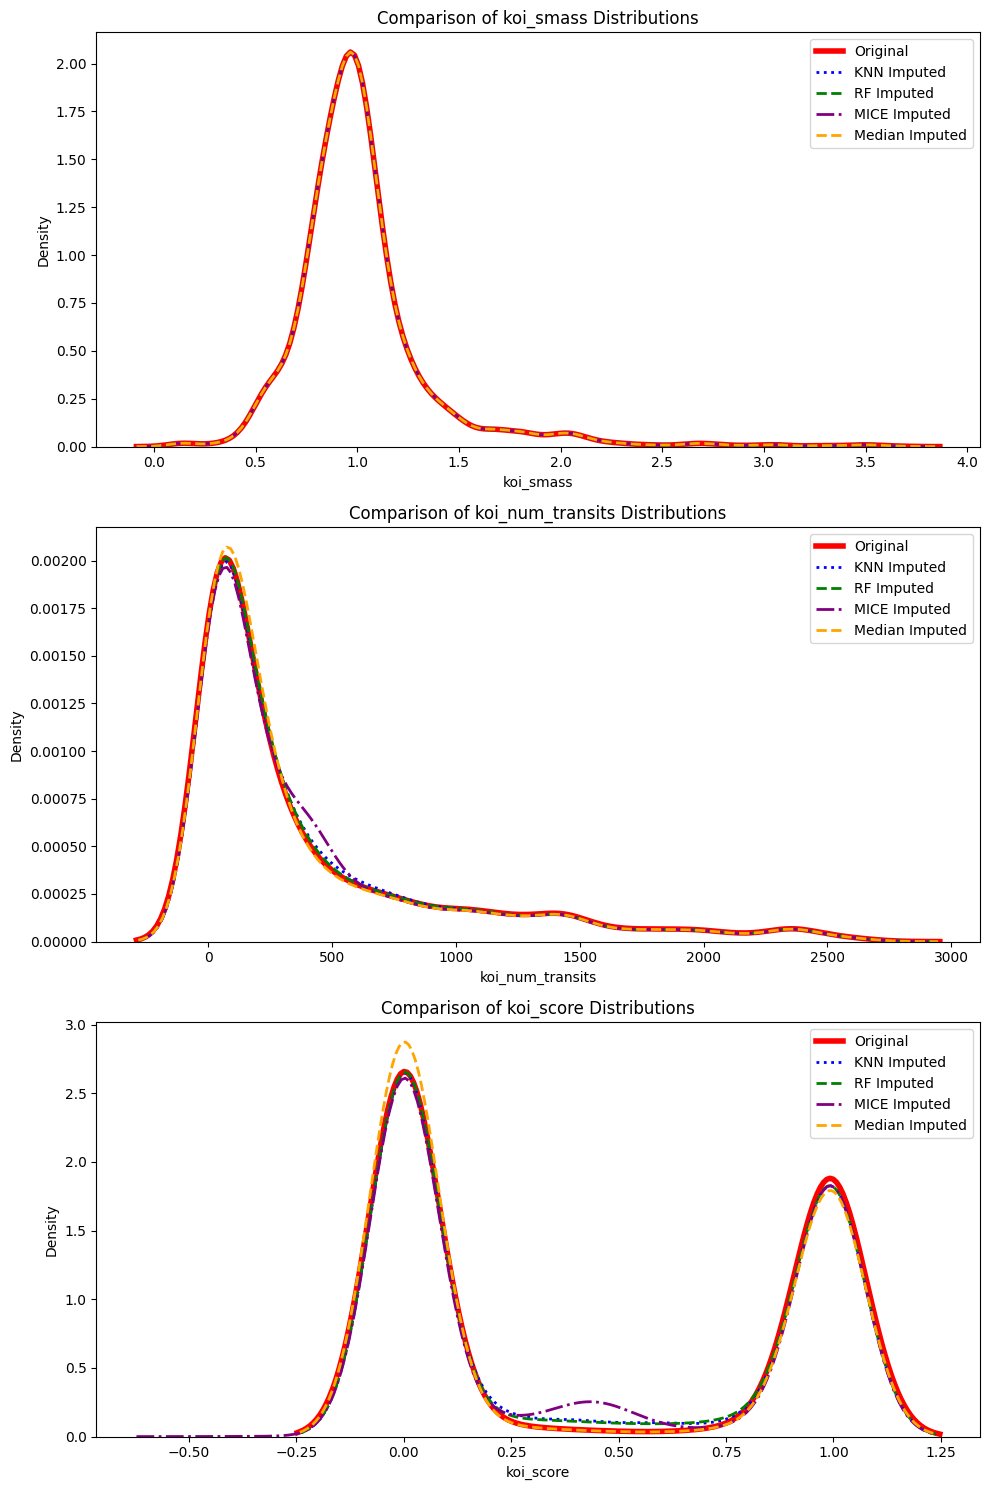

In [23]:
fig, axes = plt.subplots(len(columns_to_impute), 1, figsize=(10, 5 * len(columns_to_impute)))

for i, column in enumerate(columns_to_impute):
    sns.kdeplot(
        data=df_filtered[column], 
        label="Original", 
        ax=axes[i], 
        color="red", 
        linewidth=4,
        linestyle="solid"
    )
    sns.kdeplot(
        data=df_knn[column], 
        label="KNN Imputed", 
        ax=axes[i], 
        color="blue",
        linewidth=2,
        linestyle="dotted"
    )
    sns.kdeplot(
        data=df_rf[column], 
        label="RF Imputed", 
        ax=axes[i], 
        color="green", 
        linewidth=2,
        linestyle="--"
    )
    sns.kdeplot(
        data=df_mice[column], 
        label="MICE Imputed", 
        ax=axes[i], 
        color="purple",
        linewidth=2,
        linestyle="dashdot"
    )
    sns.kdeplot(
        data=df_median[column], 
        label="Median Imputed", 
        ax=axes[i], 
        color="orange", 
        linewidth=2,
        linestyle="dashed"
    )
    axes[i].set_title(f"Comparison of {column} Distributions")
    axes[i].legend()

plt.tight_layout()
plt.show()

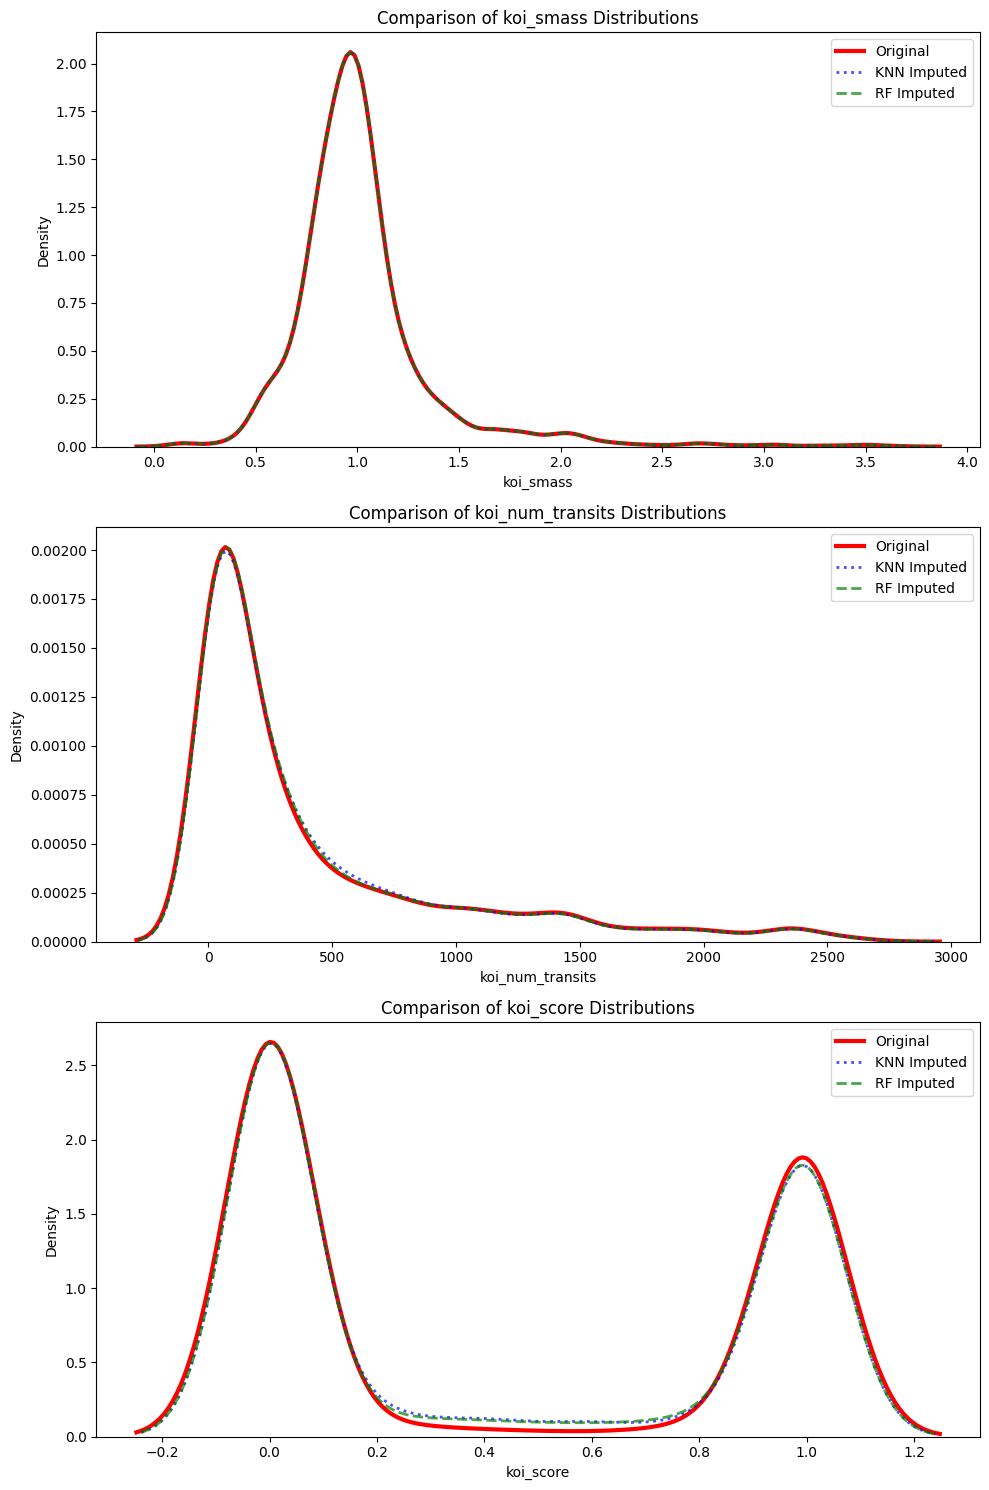

In [24]:
# Comparing KNN and RF imputers
fig, axes = plt.subplots(len(columns_to_impute), 1, figsize=(10, 5 * len(columns_to_impute)))

for i, column in enumerate(columns_to_impute):
    sns.kdeplot(
        data=df_filtered[column], 
        label="Original", 
        ax=axes[i], 
        color="red", 
        linewidth=3
    )
    sns.kdeplot(
        data=df_knn[column], 
        label="KNN Imputed", 
        ax=axes[i], 
        color="blue",
        linewidth=2,
        linestyle='dotted',
        alpha=0.7
    )
    sns.kdeplot(
        data=df_rf[column], 
        label="RF Imputed", 
        ax=axes[i], 
        color="green", 
        linewidth=2,
        linestyle='dashed',
        alpha=0.7
    )
    axes[i].set_title(f"Comparison of {column} Distributions")
    axes[i].legend()

plt.tight_layout()
plt.show()

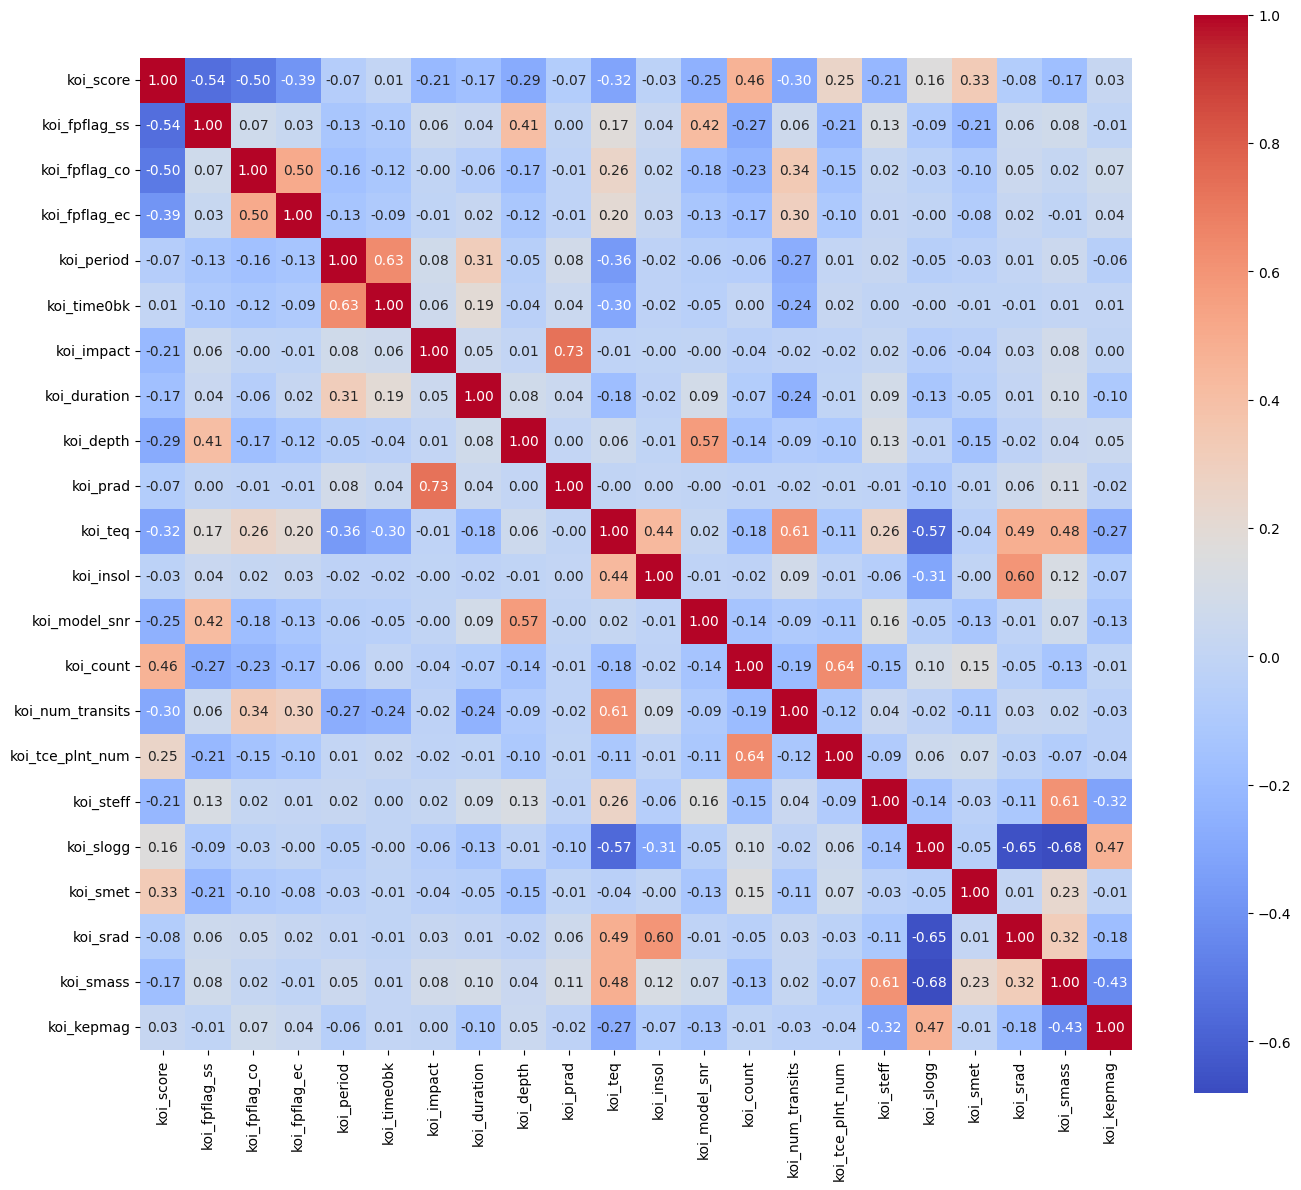

In [25]:
correlation_matrix = df_filtered.drop(columns=['koi_disposition']).corr()

# Plot the heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(
    correlation_matrix, 
    annot=True, 
    fmt=".2f", 
    cmap="coolwarm", 
    cbar=True, 
    square=True
)
plt.show()

In [33]:
from sklearn.model_selection import train_test_split
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

X = df_rf.drop(columns=['koi_disposition'])
y = df_rf['koi_disposition']

In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [28]:
brf = BalancedRandomForestClassifier()
brf.fit(X_train, y_train)

# Predict and evaluate
y_pred = brf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

/opt/miniconda3/envs/SDL/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/opt/miniconda3/envs/SDL/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/opt/miniconda3/envs/SDL/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future 

Confusion Matrix:
[[555   7]
 [  2 856]]

Classification Report:
                precision    recall  f1-score   support

     CONFIRMED       1.00      0.99      0.99       562
FALSE POSITIVE       0.99      1.00      0.99       858

      accuracy                           0.99      1420
     macro avg       0.99      0.99      0.99      1420
  weighted avg       0.99      0.99      0.99      1420



In [35]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Split resampled data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, 
    y_resampled, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_resampled
)

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [37]:
y_pred = rf.predict(X_test)

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[866   8]
 [  2 872]]

Classification Report:
                precision    recall  f1-score   support

     CONFIRMED       1.00      0.99      0.99       874
FALSE POSITIVE       0.99      1.00      0.99       874

      accuracy                           0.99      1748
     macro avg       0.99      0.99      0.99      1748
  weighted avg       0.99      0.99      0.99      1748



In [47]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, X_scaled, y, cv=5, scoring='accuracy')  # You can change 'accuracy' to other metrics like 'f1', 'roc_auc', etc.

In [48]:
print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

Cross-Validation Scores: [0.99295775 0.99366197 0.98873239 0.98802817 0.97533474]
Mean CV Accuracy: 0.9877430048933489
Standard Deviation of CV Accuracy: 0.006591705064325014


In [50]:
# Using logistic regression

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)

cv_scores = cross_val_score(lr, X_scaled, y, cv=5, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())
print("Standard Deviation of CV Accuracy:", cv_scores.std())

Cross-Validation Scores: [0.98591549 0.98873239 0.9556338  0.98239437 0.97322058]
Mean CV Accuracy: 0.9771793268419536
Standard Deviation of CV Accuracy: 0.01197390414211103


In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import (
    SMOTE,           # Standard SMOTE
    BorderlineSMOTE, # Focuses on borderline samples
    ADASYN,          # Adaptive synthetic sampling
    SVMSMOTE         # SVM-based SMOTE
)

def evaluate_smote_variants(X, y):
    # SMOTE variants to evaluate
    smote_methods = {
        'Standard SMOTE': SMOTE(random_state=42),
        'Borderline SMOTE-1': BorderlineSMOTE(random_state=42, kind='borderline-1'),
        'Borderline SMOTE-2': BorderlineSMOTE(random_state=42, kind='borderline-2'),
        'ADASYN': ADASYN(random_state=42),
        'SVM SMOTE': SVMSMOTE(random_state=42)
    }
    
    # Results storage
    results = {}
    
    # Iterate through SMOTE methods
    for smote_name, smote_method in smote_methods.items():
        print(f"\n--- Evaluating {smote_name} ---")
        
        # Apply SMOTE
        X_resampled, y_resampled = smote_method.fit_resample(X, y)
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(
            X_resampled, 
            y_resampled, 
            test_size=0.2, 
            random_state=42, 
            stratify=y_resampled
        )
        
        # Print class distribution
        print("Class Distribution After SMOTE:")
        print(pd.Series(y_resampled).value_counts())
        
        # Train Random Forest
        rf_classifier = RandomForestClassifier(
            n_estimators=100, 
            random_state=42, 
            class_weight='balanced'
        )
        rf_classifier.fit(X_train, y_train)
        
        # Predict
        y_pred = rf_classifier.predict(X_test)
        
        # Evaluation
        print("\nClassification Report:")
        report = classification_report(y_test, y_pred, output_dict=True)
        print(classification_report(y_test, y_pred))
        
        # Confusion Matrix
        print("\nConfusion Matrix:")
        conf_matrix = confusion_matrix(y_test, y_pred)
        print(conf_matrix)
        
        # Store results
        results[smote_name] = {
            'classifier': rf_classifier,
            'classification_report': report,
            'confusion_matrix': conf_matrix
        }
    
    return results

# Feature Importance Function
def get_feature_importance(results):
    feature_importance_dict = {}
    
    for smote_name, result in results.items():
        classifier = result['classifier']
        
        # Assuming X is still in scope from previous operation
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': classifier.feature_importances_
        }).sort_values('importance', ascending=False)
        
        feature_importance_dict[smote_name] = feature_importance
        
        print(f"\nTop 10 Important Features for {smote_name}:")
        print(feature_importance.head(10))
    
    return feature_importance_dict

# Usage
try:
    # Ensure X and y are prepared beforehand
    # X should be your feature DataFrame
    # y should be your target series/array
    
    # Evaluate SMOTE variants
    smote_results = evaluate_smote_variants(X_scaled, y)
    
    # Get feature importances
    feature_importances = get_feature_importance(smote_results)
    
except Exception as e:
    print("An error occurred:", e)

# Optional: Compare Overall Performance
def compare_smote_performance(results):
    print("\nSMOTE Method Performance Comparison:")
    for smote_name, result in results.items():
        avg_f1 = result['classification_report']['macro avg']['f1-score']
        print(f"{smote_name}: Macro Avg F1-Score = {avg_f1:.4f}")

# Call comparison function
compare_smote_performance(smote_results)


--- Evaluating Standard SMOTE ---
Class Distribution After SMOTE:
koi_disposition
CONFIRMED         4368
FALSE POSITIVE    4368
Name: count, dtype: int64

Classification Report:
                precision    recall  f1-score   support

     CONFIRMED       1.00      0.99      0.99       874
FALSE POSITIVE       0.99      1.00      0.99       874

      accuracy                           0.99      1748
     macro avg       0.99      0.99      0.99      1748
  weighted avg       0.99      0.99      0.99      1748


Confusion Matrix:
[[867   7]
 [  2 872]]

--- Evaluating Borderline SMOTE-1 ---
Class Distribution After SMOTE:
koi_disposition
CONFIRMED         4368
FALSE POSITIVE    4368
Name: count, dtype: int64

Classification Report:
                precision    recall  f1-score   support

     CONFIRMED       1.00      1.00      1.00       874
FALSE POSITIVE       1.00      1.00      1.00       874

      accuracy                           1.00      1748
     macro avg       1.00      

In [ ]:
from sklearn.model_selection import (
    cross_val_score,
    cross_validate,
    StratifiedKFold,
    KFold
)
from sklearn.ensemble import RandomForestClassifier

def perform_cross_validation(X, y, n_splits=5):
    # 1. Basic Cross-Validation with Multiple Metrics
    rf_classifier = RandomForestClassifier(
        n_estimators=100, 
        random_state=42, 
        class_weight='balanced'
    )
    
    # Stratified K-Fold for classification (preserves class distribution)
    stratified_kfold = StratifiedKFold(
        n_splits=n_splits, 
        shuffle=True, 
        random_state=42
    )
    
    # Comprehensive cross-validation
    cv_results = cross_validate(
        rf_classifier, 
        X_resampled, 
        y, 
        cv=stratified_kfold,
        scoring=[
            'accuracy', 
            'precision_macro', 
            'recall_macro', 
            'f1_macro'
        ],
        return_train_score=True,
        return_estimator=True  # Keeps all trained models
    )
    
    # 2. Print Detailed Results
    print("Cross-Validation Results:")
    for metric in ['test_accuracy', 'test_precision_macro', 'test_recall_macro', 'test_f1_macro']:
        print(f"{metric.replace('test_', '').capitalize()}:")
        print(f"  Mean: {cv_results[metric].mean():.4f}")
        print(f"  Std Dev: {cv_results[metric].std():.4f}")
    
    # 3. Detailed Performance for Each Fold
    performance_df = pd.DataFrame({
        'Accuracy': cv_results['test_accuracy'],
        'Precision': cv_results['test_precision_macro'],
        'Recall': cv_results['test_recall_macro'],
        'F1 Score': cv_results['test_f1_macro']
    })
    print("\nPerformance by Fold:")
    print(performance_df)
    
    # 4. Feature Importance Across Folds
    feature_importances = []
    for estimator in cv_results['estimator']:
        fold_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': estimator.feature_importances_
        }).sort_values('importance', ascending=False)
        feature_importances.append(fold_importance)
    
    # Average Feature Importance
    avg_feature_importance = pd.DataFrame({
        'feature': X.columns,
        'mean_importance': np.mean([fi['importance'] for fi in feature_importances], axis=0),
        'std_importance': np.std([fi['importance'] for fi in feature_importances], axis=0)
    }).sort_values('mean_importance', ascending=False)
    
    print("\nAverage Feature Importance:")
    print(avg_feature_importance.head(10))
    
    return {
        'cv_results': cv_results,
        'performance_df': performance_df,
        'feature_importances': avg_feature_importance
    }

# Alternative Detailed Cross-Validation
def advanced_cross_validation(X, y):
    # Multiple Cross-Validation Strategies
    cv_strategies = {
        'Stratified K-Fold': StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        'Standard K-Fold': KFold(n_splits=5, shuffle=True, random_state=42)
    }
    
    results = {}
    
    for name, cv in cv_strategies.items():
        print(f"\n--- {name} Results ---")
        
        # Individual Metrics
        scores = {
            'Accuracy': cross_val_score(
                RandomForestClassifier(random_state=42), 
                X, y, cv=cv, scoring='accuracy'
            ),
            'Precision': cross_val_score(
                RandomForestClassifier(random_state=42), 
                X, y, cv=cv, scoring='precision_macro'
            ),
            'Recall': cross_val_score(
                RandomForestClassifier(random_state=42), 
                X, y, cv=cv, scoring='recall_macro'
            ),
            'F1': cross_val_score(
                RandomForestClassifier(random_state=42), 
                X, y, cv=cv, scoring='f1_macro'
            )
        }
        
        # Print Results
        for metric, score in scores.items():
            print(f"{metric}:")
            print(f"  Mean: {score.mean():.4f}")
            print(f"  Std Dev: {score.std():.4f}")
    
    return results

# Usage
# Assuming X and y are your feature matrix and target variable
try:
    # Perform comprehensive cross-validation
    cv_results = perform_cross_validation(X, y)
    
    # Optional: Run advanced cross-validation
    advanced_results = advanced_cross_validation(X, y)
    
except Exception as e:
    print("An error occurred:", e)

In [52]:
import pickle

# Save the model to a file
with open('random_forest_model.pkl', 'wb') as model_file:
    pickle.dump(rf, model_file)

print("Model exported as random_forest_model.pkl")

Model exported as random_forest_model.pkl


In [57]:
len(X.columns)

22

In [60]:
df_rf

,koi_disposition,koi_score,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_time0bk,koi_impact,koi_duration,koi_depth,koi_prad,koi_teq,koi_insol,koi_model_snr,koi_count,koi_num_transits,koi_tce_plnt_num,koi_steff,koi_slogg,koi_smet,koi_srad,koi_smass,koi_kepmag
0,CONFIRMED,1.000,0,0,0,9.488036,170.538750,0.146,2.95750,615.8,2.26,793.0,93.59,35.8,2,142.0,1.0,5455.0,4.467,0.14,0.927,0.919,15.347
1,CONFIRMED,0.969,0,0,0,54.418383,162.513840,0.586,4.50700,874.8,2.83,443.0,9.11,25.8,2,25.0,2.0,5455.0,4.467,0.14,0.927,0.919,15.347
3,FALSE POSITIVE,0.000,1,0,0,1.736952,170.307565,1.276,2.40641,8079.2,33.46,1395.0,891.96,505.6,1,621.0,1.0,5805.0,4.564,-0.52,0.791,0.836,15.597
4,CONFIRMED,1.000,0,0,0,2.525592,171.595550,0.701,1.65450,603.3,2.75,1406.0,926.16,40.9,1,515.0,1.0,6031.0,4.438,0.07,1.046,1.095,15.509
5,CONFIRMED,1.000,0,0,0,11.094321,171.201160,0.538,4.59450,1517.5,3.90,835.0,114.81,66.5,3,95.0,1.0,6046.0,4.486,-0.08,0.972,1.053,15.714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9557,FALSE POSITIVE,0.008,0,0,0,373.893980,261.496800,0.963,27.66000,730.0,2.51,206.0,0.42,18.5,1,4.0,3.0,5263.0,4.574,-0.66,0.699,0.668,14.911
9558,FALSE POSITIVE,0.000,0,0,1,8.589871,132.016100,0.765,4.80600,87.7,1.11,929.0,176.40,8.4,1,125.0,1.0,5638.0,4.296,-0.16,1.088,0.856,14.478
9559,FALSE POSITIVE,0.000,1,1,0,0.527699,131.705093,1.252,3.22210,1579.2,29.35,2088.0,4500.53,453.3,1,2026.0,1.0,5638.0,4.529,0.14,0.903,1.005,14.082
9561,FALSE POSITIVE,0.021,0,1,0,0.681402,132.181750,0.147,0.86500,103.6,1.07,2218.0,5713.41,12.3,1,1969.0,1.0,6173.0,4.447,-0.04,1.041,1.104,15.385


In [63]:
df_rf['koi_disposition'].value_counts()

koi_disposition
FALSE POSITIVE    4368
CONFIRMED         2731
Name: count, dtype: int64